<a href="https://colab.research.google.com/github/minassy/ISID_2021/blob/main/210906_EDA_train.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os
import zipfile
import glob
import pandas as pd
import numpy as np
import pathlib
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
#作業基本ディレクトリ
DIR = 'drive/MyDrive/00_Competition/ISID/2021'
os.listdir(DIR)
#os.mkdir(DIR+'/data')

['data', '210904_学習データの読み込み.ipynb', '210906_EDA.ipynb']

In [3]:
os.listdir(os.path.join(DIR, 'data', 'Train_Unit_20210903'))

['Train_Unit_3', 'Train_Unit_2', 'Train_Unit_1', 'dataset_train_all.csv']

In [4]:
#データの読み込み
df_0 = pd.read_csv(
    os.path.join(DIR, 'data', 'Train_Unit_20210903', 'dataset_train_all.csv'),
    encoding='utf-8')

In [5]:
#不必要なIndex列と空白列を削除。
df_0 = df_0.drop(df_0.columns[[0, 7]], axis=1)

In [6]:
#データ処理用にDFをコピー
df = df_0.copy()

In [7]:
df.head()

,Time (s),Voltage Measured (V),Voltage Charge (V),Current Measured (Amps),Current Charge (Amps),Temperature (degree C),unit,charge_mode,Cycle_num,Voltage Load (V),Current Load (Amps)
0,0.000,3.6927,0.003,-0.004495,0.000,25.663,Train_Unit_3,Charge,90,NaN,NaN
1,2.453,3.1721,1.462,-3.573100,-3.563,25.660,Train_Unit_3,Charge,90,NaN,NaN
2,8.921,3.8846,4.618,1.505800,1.498,25.743,Train_Unit_3,Charge,90,NaN,NaN
3,15.156,3.9054,4.650,1.506600,1.500,25.835,Train_Unit_3,Charge,90,NaN,NaN
4,21.750,3.9165,4.661,1.509000,1.500,25.884,Train_Unit_3,Charge,90,NaN,NaN


In [8]:
df.columns

Index(['Time (s)', 'Voltage Measured (V)', 'Voltage Charge (V)',
       'Current Measured (Amps)', 'Current Charge (Amps)',
       'Temperature (degree C)', 'unit', 'charge_mode', 'Cycle_num',
       'Voltage Load (V)', 'Current Load (Amps)'],
      dtype='object')

In [9]:
#カラム名変更前後の辞書
col_list = {'Time (s)' : 'Time',
            'Voltage Measured (V)' : 'VM',
            'Voltage Charge (V)' : 'VC',
            'Current Measured (Amps)' : 'CM', 
            'Current Charge (Amps)' : 'CC',
            'Temperature (degree C)': 'Temp', 
            'unit' : 'unit_name', 
            'charge_mode' : 'mode', 
            'Cycle_num' : 'Cycle',
            'Voltage Load (V)' : 'VL',
            'Current Load (Amps)' : 'CL'
}

【カラムの情報】  
充電/放電共通  
Time (s)：サイクル内での経過時間 (s)  
Voltage Measured (V)：バッテリーターミナルでの電圧 (Volts)  
Current Measured (Amps)：バッテリー出力電流 (Amps)  
Temperature (degree C)：バッテリー温度 (℃)  
  
充電  
Voltage Load (V)：負荷で測定された電圧 (Volts)  
Current Load (Amps)：負荷で測定された電流 (Amps)    
  
放電  
Voltage Charge (V)：充電器で測定された電圧 (Volts)  
Current Charge (Amps)：充電器で測定された電流 (Amps)  

In [10]:
df = df.rename(columns=col_list)
df.head()

,Time,VM,VC,CM,CC,Temp,unit_name,mode,Cycle,VL,CL
0,0.000,3.6927,0.003,-0.004495,0.000,25.663,Train_Unit_3,Charge,90,NaN,NaN
1,2.453,3.1721,1.462,-3.573100,-3.563,25.660,Train_Unit_3,Charge,90,NaN,NaN
2,8.921,3.8846,4.618,1.505800,1.498,25.743,Train_Unit_3,Charge,90,NaN,NaN
3,15.156,3.9054,4.650,1.506600,1.500,25.835,Train_Unit_3,Charge,90,NaN,NaN
4,21.750,3.9165,4.661,1.509000,1.500,25.884,Train_Unit_3,Charge,90,NaN,NaN


In [11]:
DIR_DATA_TRAIN = os.path.join(DIR, 'data', 'Train_Unit_20210903')
for folder in os.listdir(DIR_DATA_TRAIN)[:3]:
  for C in os.listdir(os.path.join(DIR_DATA_TRAIN, folder)):
    files = glob.glob(os.path.join(DIR_DATA_TRAIN, folder, C, '*.csv'))
    print(f'{folder}','--',f'{C}のサイクル数：',len(files))

Train_Unit_3 -- Chargeのサイクル数： 97
Train_Unit_3 -- Dischargeのサイクル数： 97
Train_Unit_2 -- Chargeのサイクル数： 40
Train_Unit_2 -- Dischargeのサイクル数： 40
Train_Unit_1 -- Chargeのサイクル数： 124
Train_Unit_1 -- Dischargeのサイクル数： 124


# EDA

・充電と放電における挙動の変化を確認する。  
・サイクルの初めと終わりでデータに変化があるか？を確認する。

In [12]:
df.columns

Index(['Time', 'VM', 'VC', 'CM', 'CC', 'Temp', 'unit_name', 'mode', 'Cycle',
       'VL', 'CL'],
      dtype='object')

In [13]:
#ユニット毎、充電モード毎について、1サイクル目、中間サイクル、最終サイクルを比較
def plot_eda(unit, mode, cols, cycle_first, cycle_mid, cycle_final):
  df_plot_first = df[(df['mode'] == mode) & (df['Cycle'] == cycle_first) & (df['unit_name'] == unit)]
  df_plot_mid = df[(df['mode'] == mode) & (df['Cycle'] == cycle_mid) & (df['unit_name'] == unit)]
  df_plot_final = df[(df['mode'] == mode) & (df['Cycle'] == cycle_final) & (df['unit_name'] == unit)]

  for col in cols:
    fig, ax = plt.subplots(figsize=(15,5), facecolor = 'w')
    ax.plot(df_plot_first['Time'], df_plot_first[col], label=f'Cycle_{cycle_first}')
    ax.plot(df_plot_mid['Time'], df_plot_mid[col], label=f'Cycle_{cycle_mid}')
    ax.plot(df_plot_final['Time'], df_plot_final[col], label=f'Cycle_{cycle_final}')
    plt.title('Change over time_'+col)
    plt.xlabel('Time')
    plt.ylabel(col)

    plt.legend()
  plt.show()

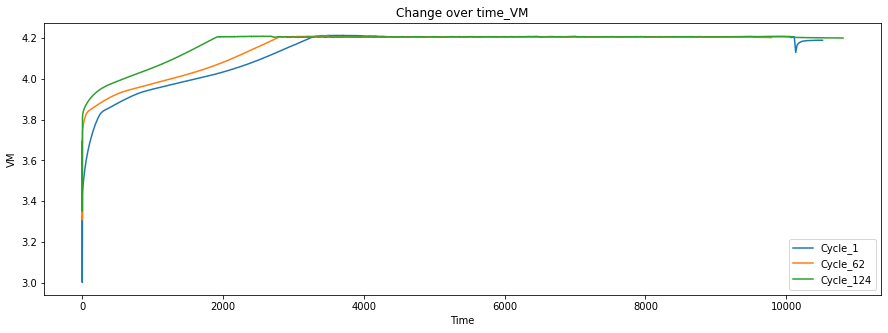

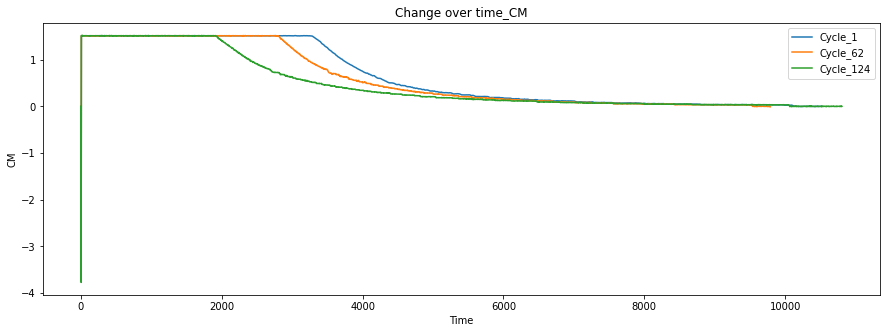

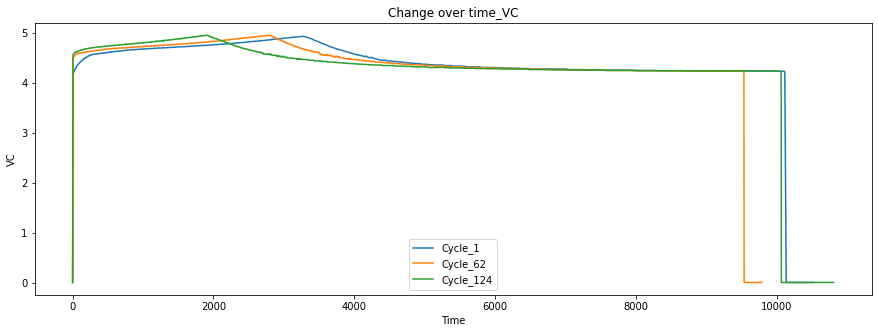

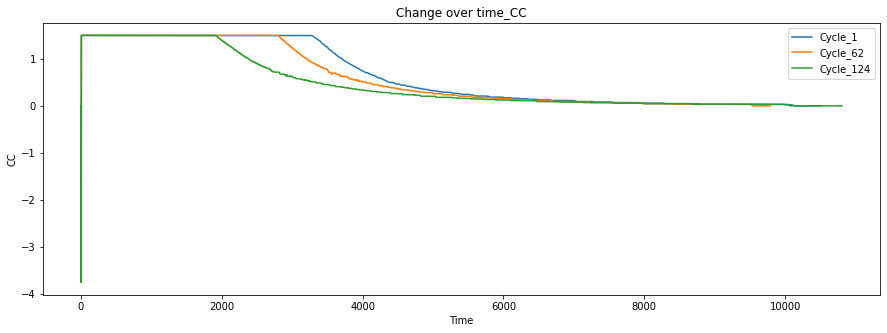

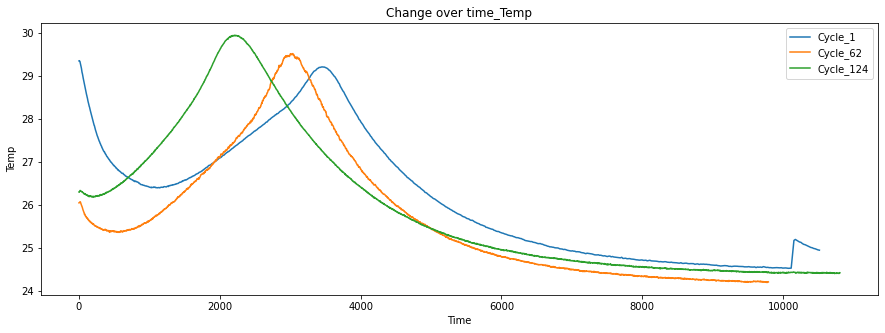

NameError: ignored

In [20]:
#ユニット1、充電
unit = 'Train_Unit_1'
mode =  'Charge'
cols = ['VM', 'CM', 'VC', 'CC', 'Temp']
#mode =  'Discharge'
#cols = ['VM', 'CM', 'VL', 'CL', 'Temp']

cycle_first = 1
cycle_mid = 62
cycle_final = 124

plot_eda(unit, mode, cols, cycle_first, cycle_mid, cycle_final)

【充電】ユニット1  
①VM：サイクルを経るごとに、傾きが立ってくる。飽和までの時間が短くなる。  
②VC：サイクルを経るごとに、ピークに達するまでの時間が短くなってくる。  
③CM：サイクルを経るごとに、下がり始めの時間が短くなってくる。  
④CC：CMと同様の傾向。⇒CMとの多重共線性に気を付ける。  
⑤温度：(1)サイクルを経るごとに、初期測定温度が低い。(2)ピーク点が短くなってくる。  

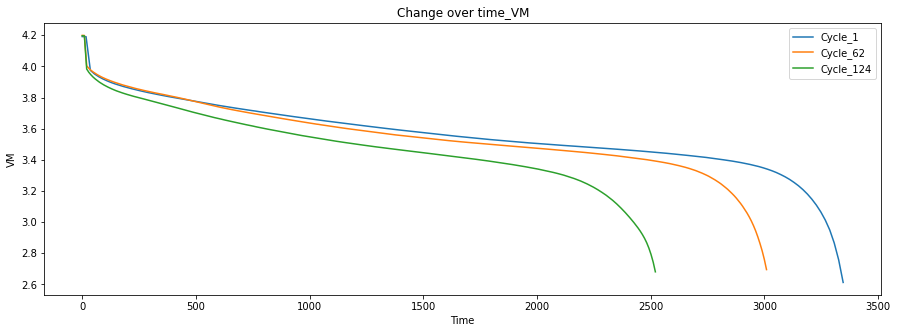

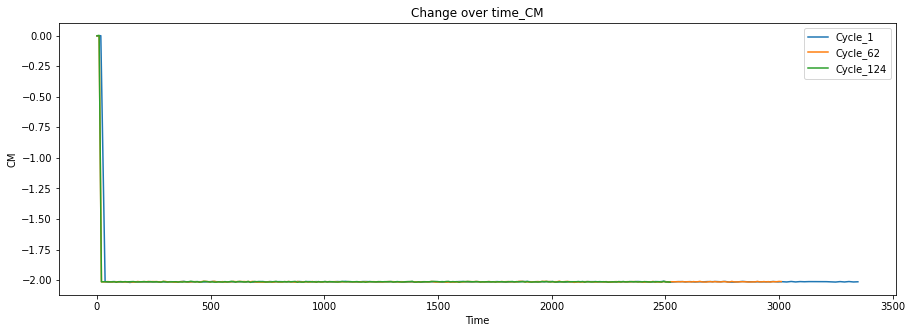

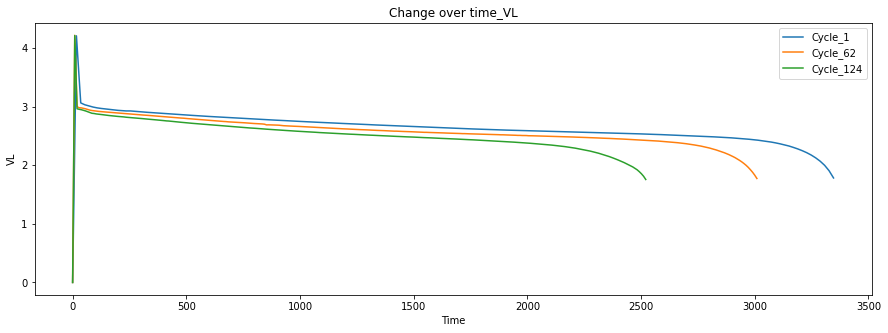

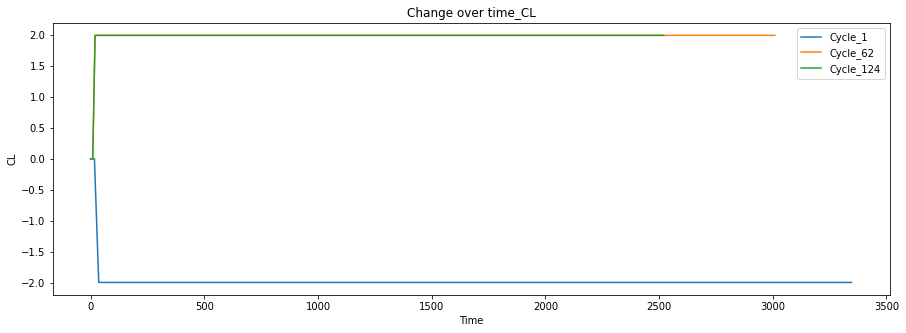

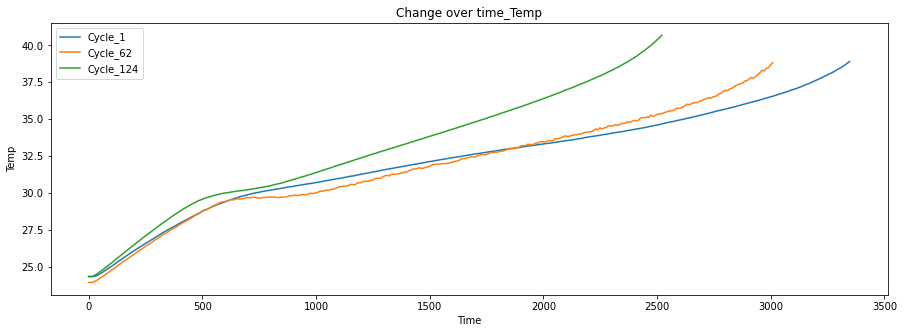

In [15]:
#ユニット1、放電
unit = 'Train_Unit_1'
#mode =  'Charge'
#cols = ['VM', 'CM', 'VC', 'CC', 'Temp']
mode =  'Discharge'
cols = ['VM', 'CM', 'VL', 'CL', 'Temp']

cycle_first = 1
cycle_mid = 62
cycle_final = 124

plot_eda(unit, mode, cols, cycle_first, cycle_mid, cycle_final)

【放電】ユニット1  
①VM：サイクルを経るごとに、到達時間が短くなる。  
②CM：あまり差がない？⇒特徴量として使いにくい？
③VL：VMと同様の傾向。⇒CMとの多重共線性に気を付ける。  
④CL：サイクルを経るごとに、ドラスティックに正負が逆になる。但し、中間と最終の差がでない。⇒特徴量として使いにくい？  
⑤温度：充電時とかなり挙動が異なる。サイクルを経るごとに、高温になるまでの時間が短い。

・EDAをもとに、ユニット間での比較をおこなう。

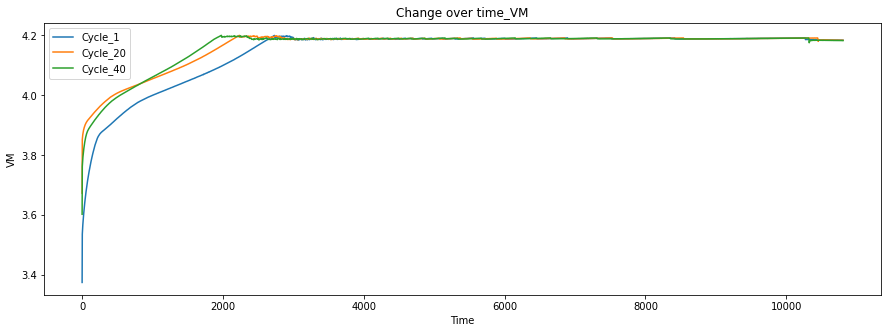

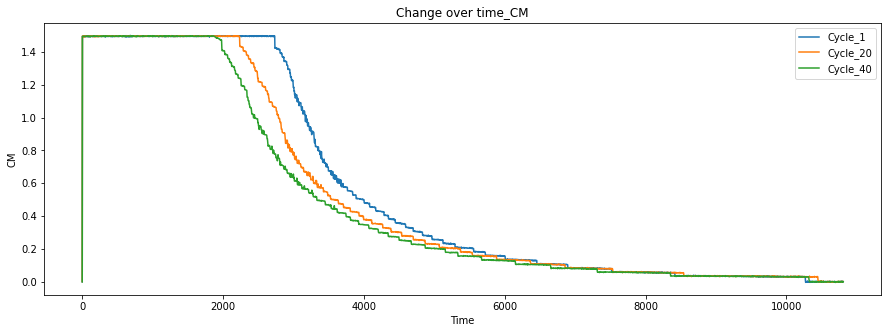

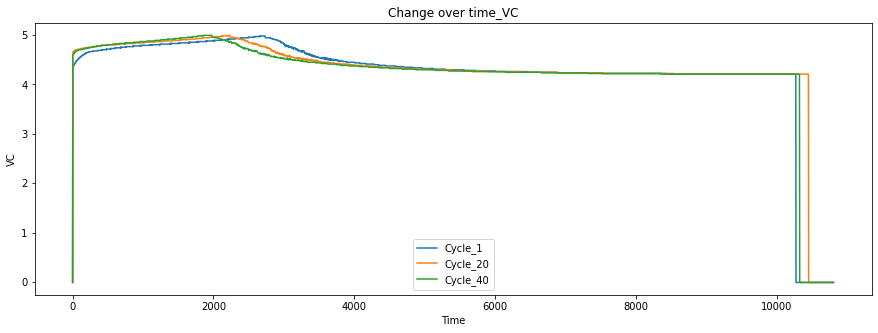

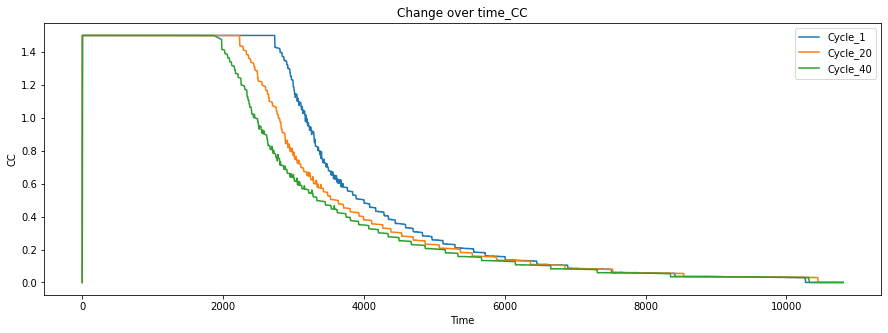

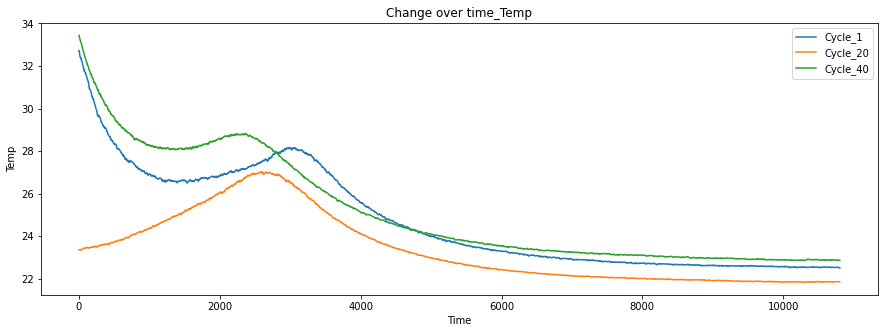

In [16]:
#ユニット2、充電
unit = 'Train_Unit_2'
mode =  'Charge'
cols = ['VM', 'CM', 'VC', 'CC', 'Temp']
#mode =  'Discharge'
#cols = ['VM', 'CM', 'VL', 'CL', 'Temp']

cycle_first = 1
cycle_mid = 20
cycle_final = 40

plot_eda(unit, mode, cols, cycle_first, cycle_mid, cycle_final)

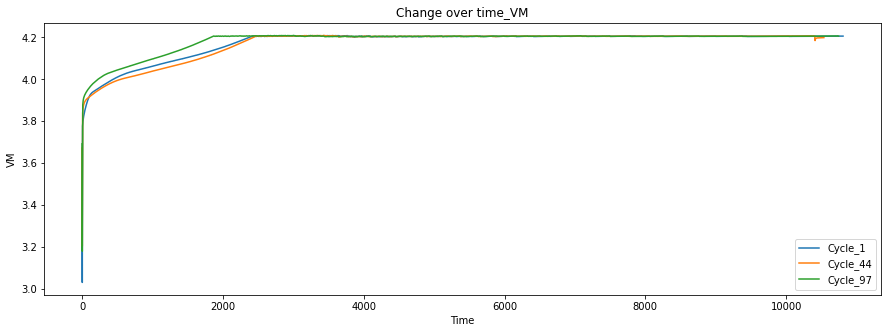

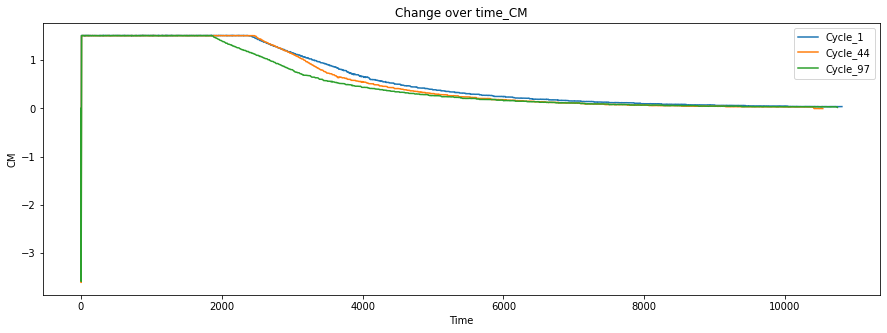

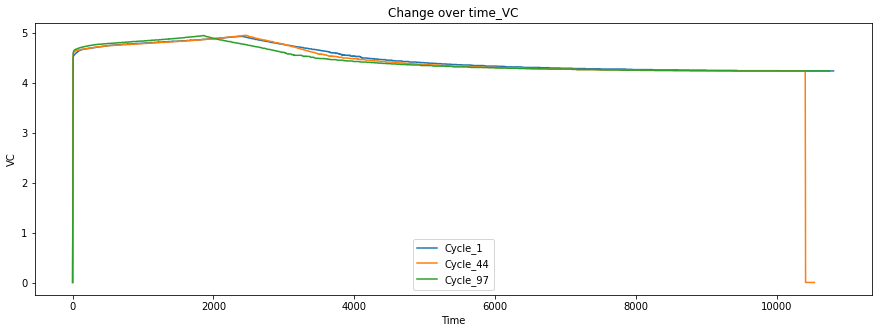

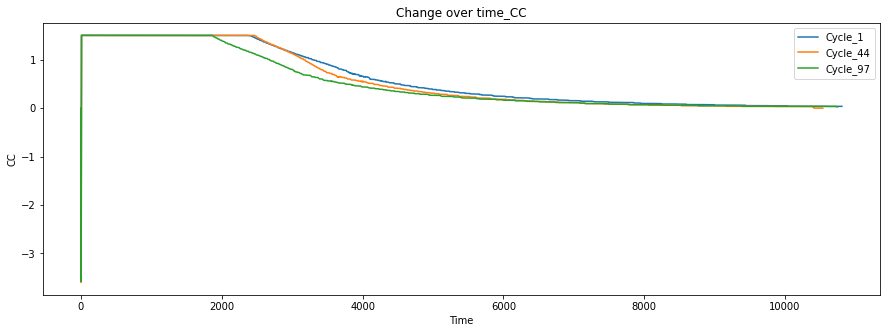

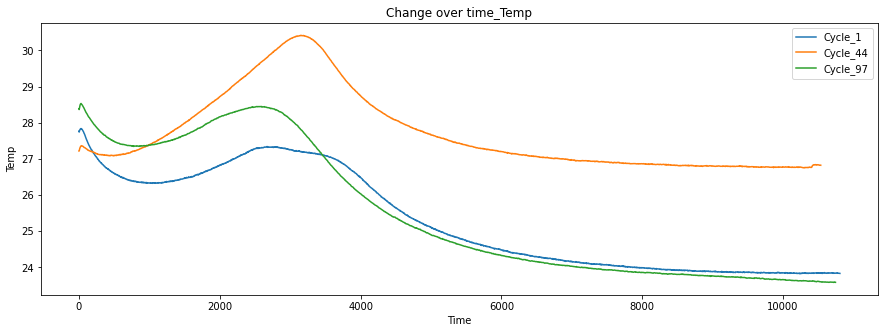

In [17]:
#ユニット3、充電
unit = 'Train_Unit_3'
mode =  'Charge'
cols = ['VM', 'CM', 'VC', 'CC', 'Temp']
#mode =  'Discharge'
#cols = ['VM', 'CM', 'VL', 'CL', 'Temp']

cycle_first = 1
cycle_mid = 44
cycle_final = 97

plot_eda(unit, mode, cols, cycle_first, cycle_mid, cycle_final)

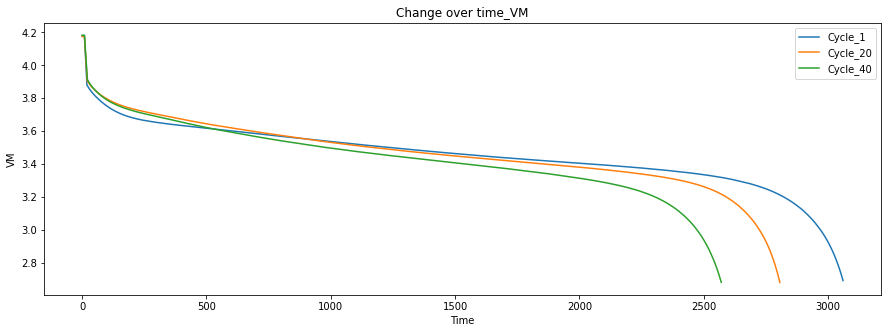

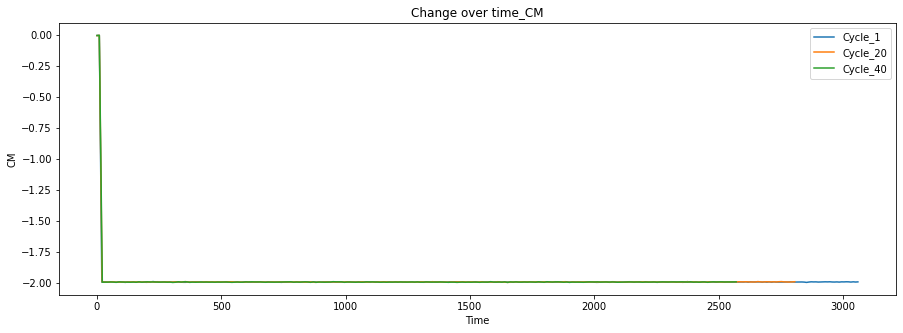

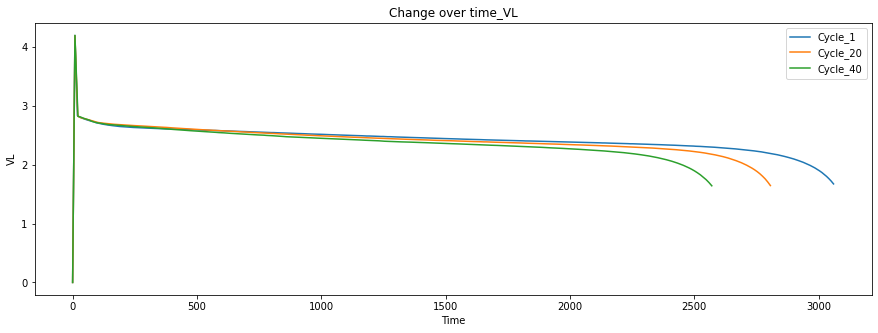

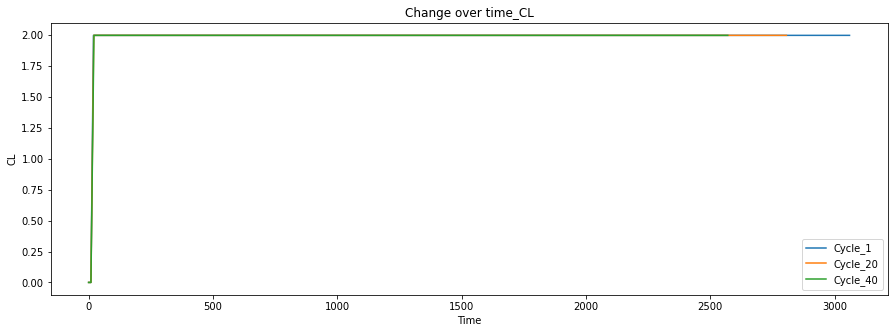

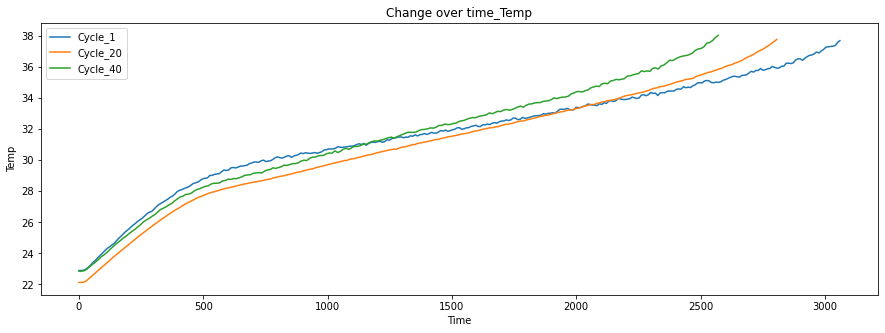

In [18]:
#ユニット2、放電
unit = 'Train_Unit_2'
#mode =  'Charge'
#cols = ['VM', 'CM', 'VC', 'CC', 'Temp']
mode =  'Discharge'
cols = ['VM', 'CM', 'VL', 'CL', 'Temp']

cycle_first = 1
cycle_mid = 20
cycle_final = 40

plot_eda(unit, mode, cols, cycle_first, cycle_mid, cycle_final)

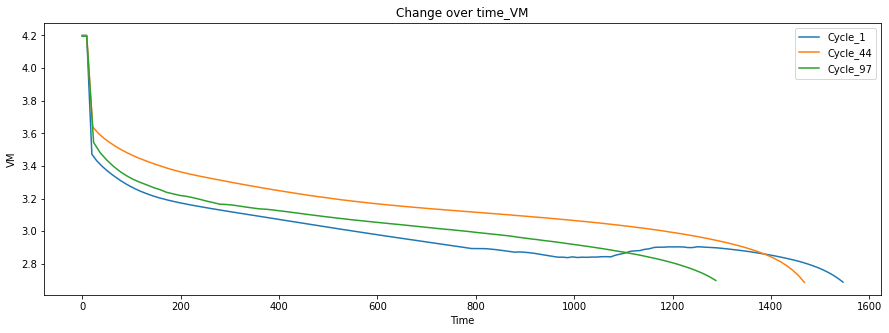

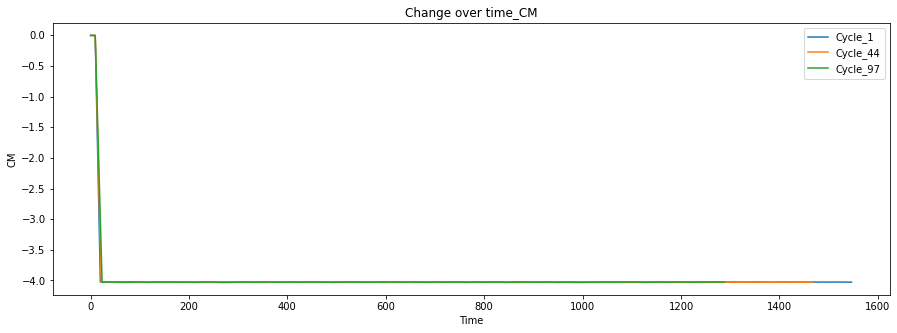

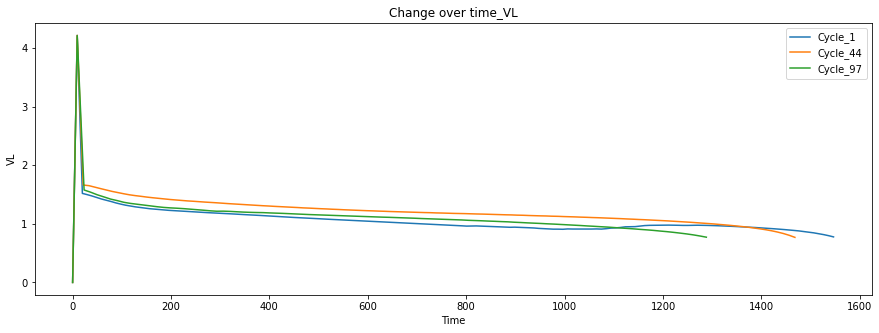

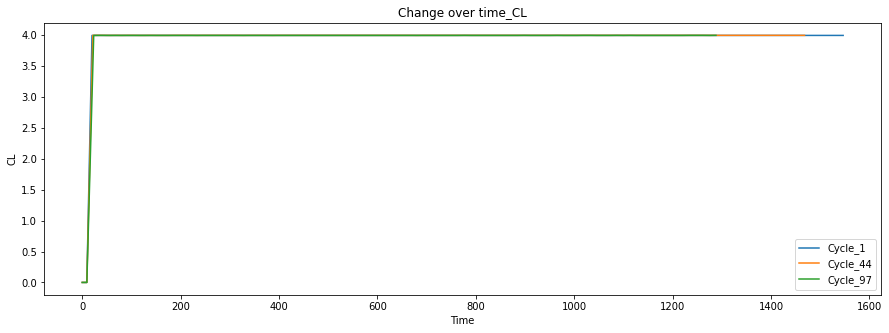

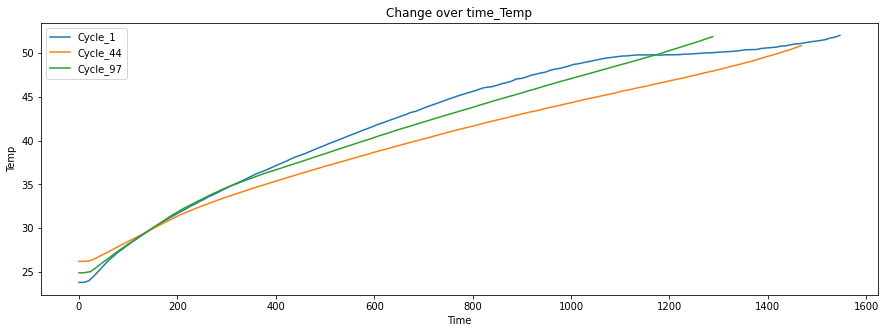

In [19]:
#ユニット3、放電
unit = 'Train_Unit_3'
#mode =  'Charge'
#cols = ['VM', 'CM', 'VC', 'CC', 'Temp']
mode =  'Discharge'
cols = ['VM', 'CM', 'VL', 'CL', 'Temp']

cycle_first = 1
cycle_mid = 44
cycle_final = 97

plot_eda(unit, mode, cols, cycle_first, cycle_mid, cycle_final)

・ユニット間比較用のグラフ

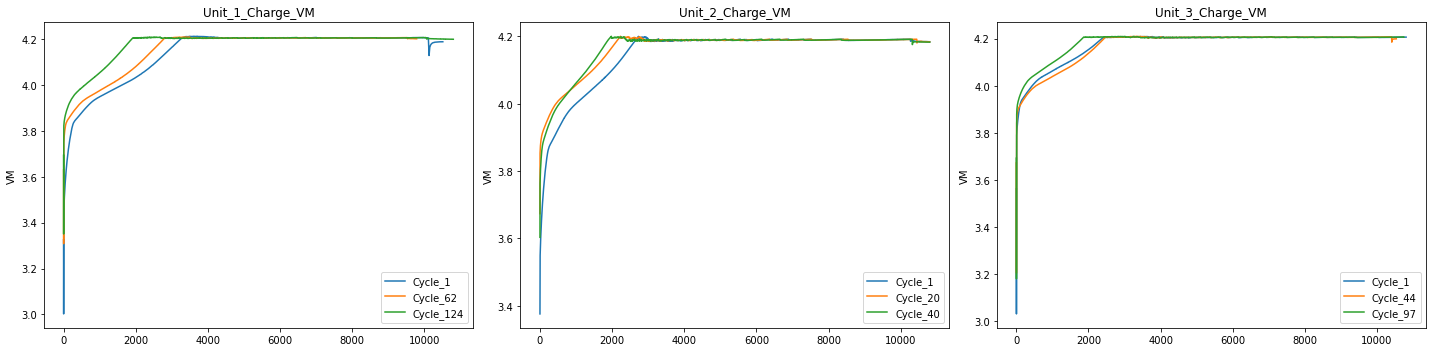

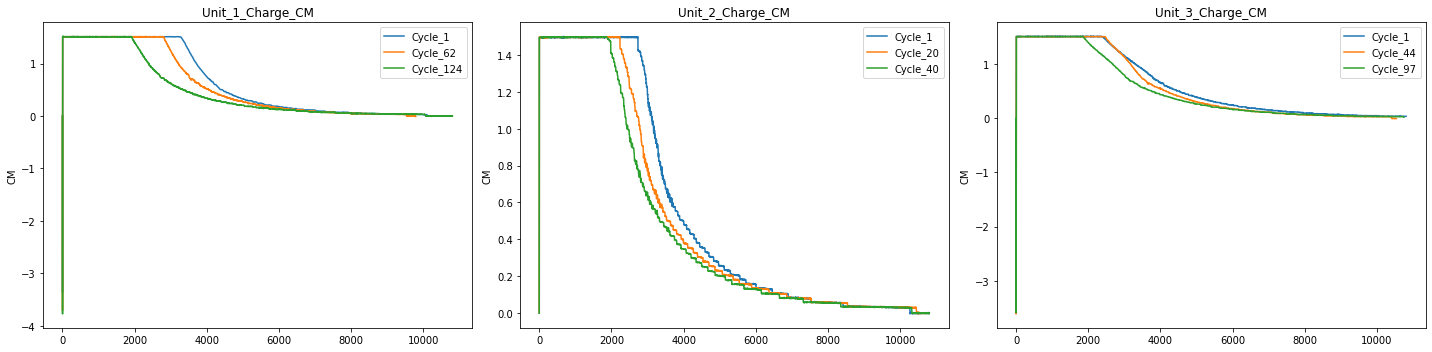

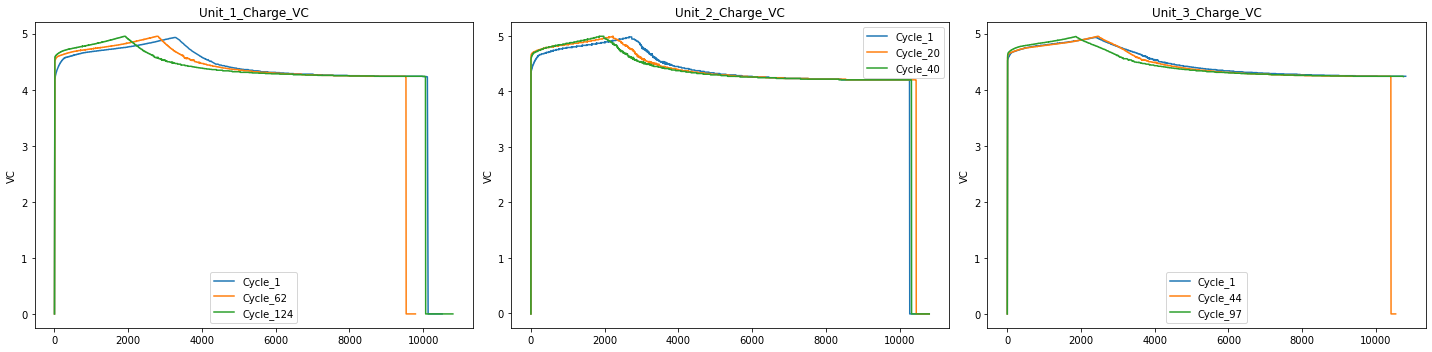

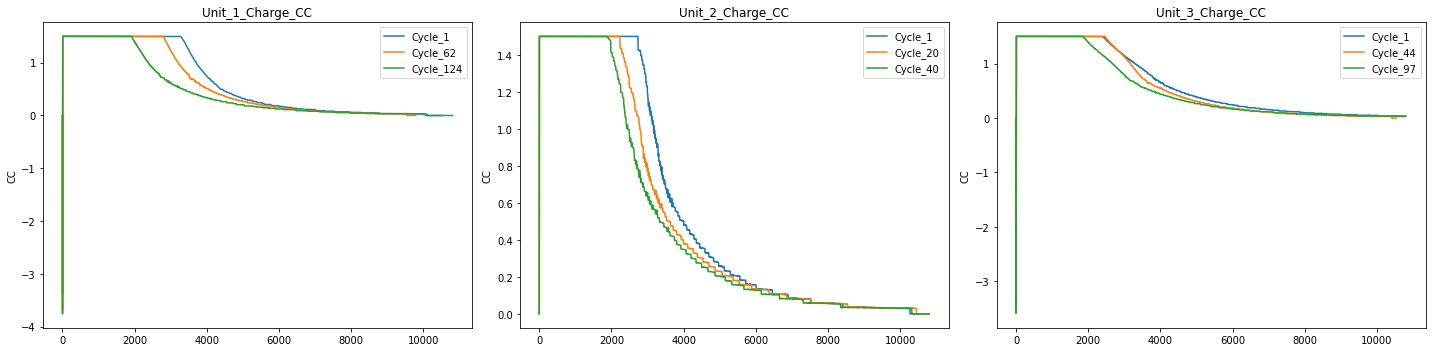

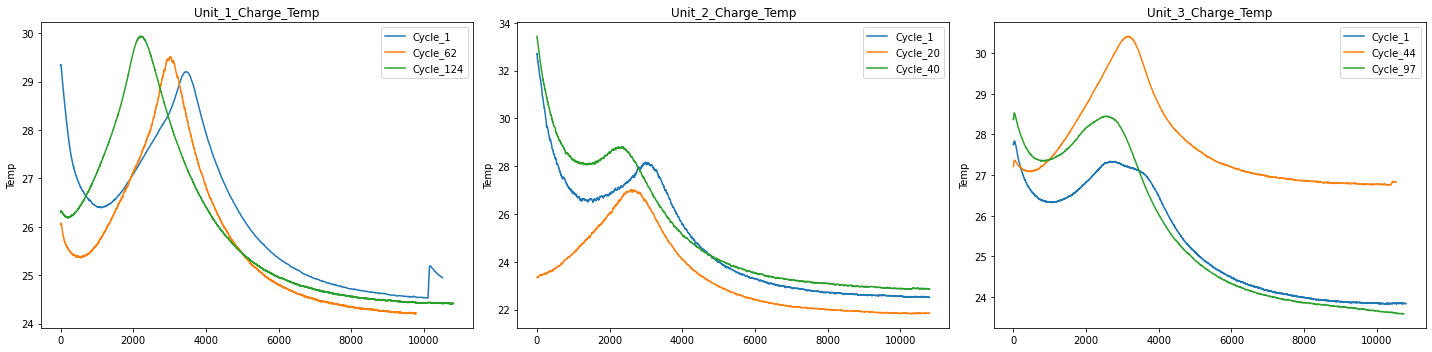

In [35]:
#充電
mode =  'Charge'
#mode =  'Discharge'

cols = ['VM', 'CM', 'VC', 'CC', 'Temp']
#cols = ['VM', 'CM', 'VL', 'CL', 'Temp']

for col in cols:
  fig = plt.figure(figsize=(20,5))

  ax1 = fig.add_subplot(1, 3, 1)#unit1
  ax2 = fig.add_subplot(1, 3, 2)#unit2
  ax3 = fig.add_subplot(1, 3, 3)#unit3

  #ユニット1
  unit = 'Train_Unit_1'

  ax1_cycle_first = 1
  ax1_cycle_mid = 62
  ax1_cycle_final = 124

  ax1_first = df[(df['mode'] == mode) & (df['Cycle'] == ax1_cycle_first) & (df['unit_name'] == unit)]
  ax1_mid = df[(df['mode'] == mode) & (df['Cycle'] == ax1_cycle_mid) & (df['unit_name'] == unit)]
  ax1_final = df[(df['mode'] == mode) & (df['Cycle'] == ax1_cycle_final) & (df['unit_name'] == unit)]

  ax1.plot(ax1_first['Time'], ax1_first[col], label=f'Cycle_{ax1_cycle_first}')
  ax1.plot(ax1_mid['Time'], ax1_mid[col], label=f'Cycle_{ax1_cycle_mid}')
  ax1.plot(ax1_final['Time'], ax1_final[col], label=f'Cycle_{ax1_cycle_final}')
  ax1.set_title(f'Unit_1_{mode}_{col}')
  ax1.set_ylabel(col)
  ax1.legend()

  #ユニット2
  unit = 'Train_Unit_2'

  ax2_cycle_first = 1
  ax2_cycle_mid = 20
  ax2_cycle_final = 40

  ax2_first = df[(df['mode'] == mode) & (df['Cycle'] == ax2_cycle_first) & (df['unit_name'] == unit)]
  ax2_mid = df[(df['mode'] == mode) & (df['Cycle'] == ax2_cycle_mid) & (df['unit_name'] == unit)]
  ax2_final = df[(df['mode'] == mode) & (df['Cycle'] == ax2_cycle_final) & (df['unit_name'] == unit)]

  ax2.plot(ax2_first['Time'], ax2_first[col], label=f'Cycle_{ax2_cycle_first}')
  ax2.plot(ax2_mid['Time'], ax2_mid[col], label=f'Cycle_{ax2_cycle_mid}')
  ax2.plot(ax2_final['Time'], ax2_final[col], label=f'Cycle_{ax2_cycle_final}')
  ax2.set_title(f'Unit_2_{mode}_{col}')
  ax2.set_ylabel(col)
  ax2.legend()

  #ユニット3
  unit = 'Train_Unit_3'

  ax3_cycle_first = 1
  ax3_cycle_mid = 44
  ax3_cycle_final = 97

  ax3_first = df[(df['mode'] == mode) & (df['Cycle'] == ax3_cycle_first) & (df['unit_name'] == unit)]
  ax3_mid = df[(df['mode'] == mode) & (df['Cycle'] == ax3_cycle_mid) & (df['unit_name'] == unit)]
  ax3_final = df[(df['mode'] == mode) & (df['Cycle'] == ax3_cycle_final) & (df['unit_name'] == unit)]

  ax3.plot(ax3_first['Time'], ax3_first[col], label=f'Cycle_{ax3_cycle_first}')
  ax3.plot(ax3_mid['Time'], ax3_mid[col], label=f'Cycle_{ax3_cycle_mid}')
  ax3.plot(ax3_final['Time'], ax3_final[col], label=f'Cycle_{ax3_cycle_final}')
  ax3.set_title(f'Unit_3_{mode}_{col}')
  ax3.set_ylabel(col)
  ax3.legend()

  fig.tight_layout()
  plt.show()

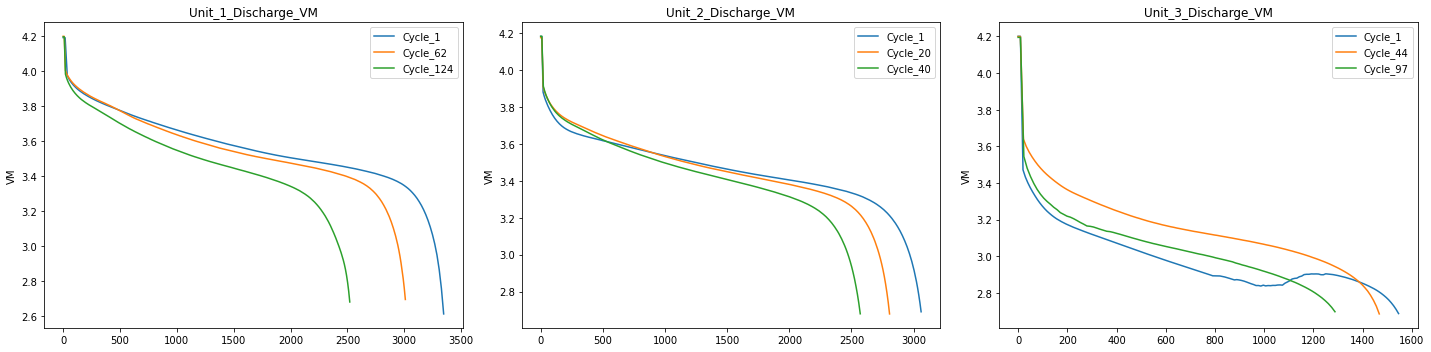

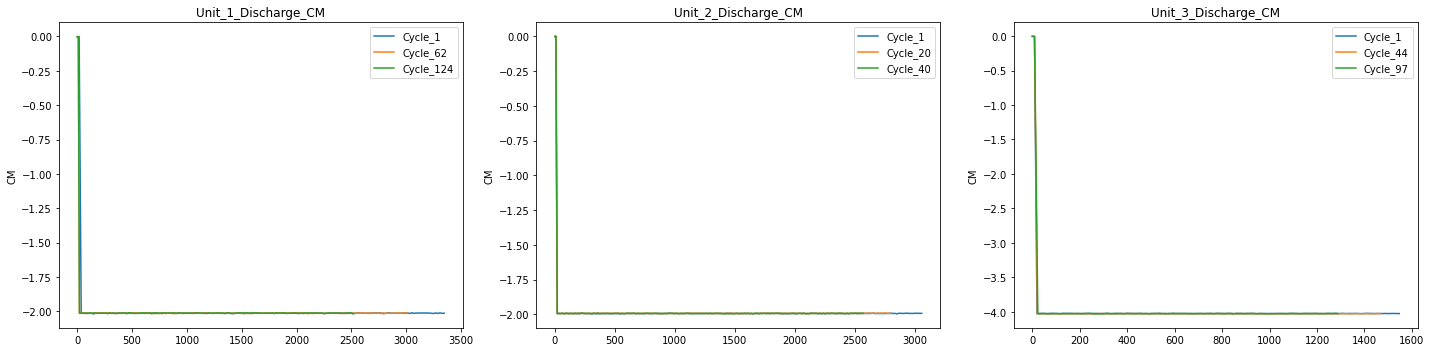

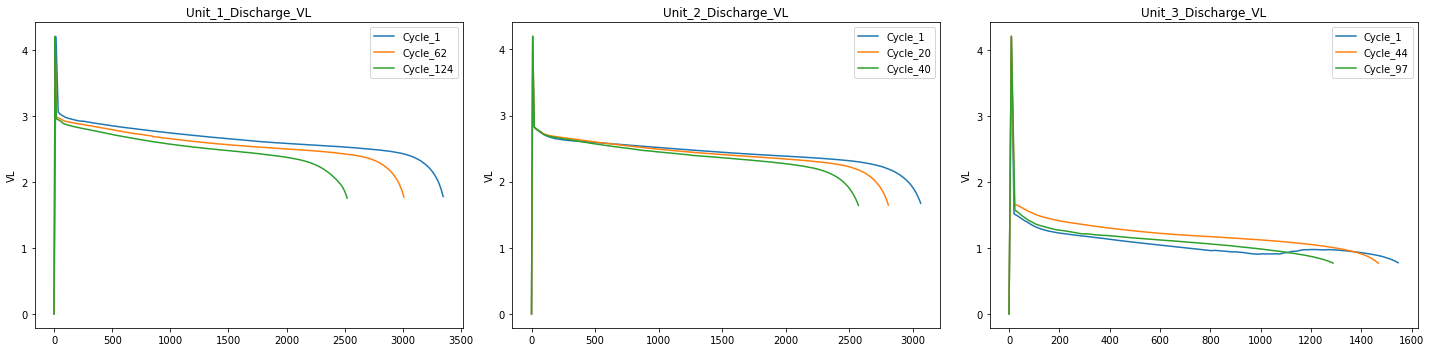

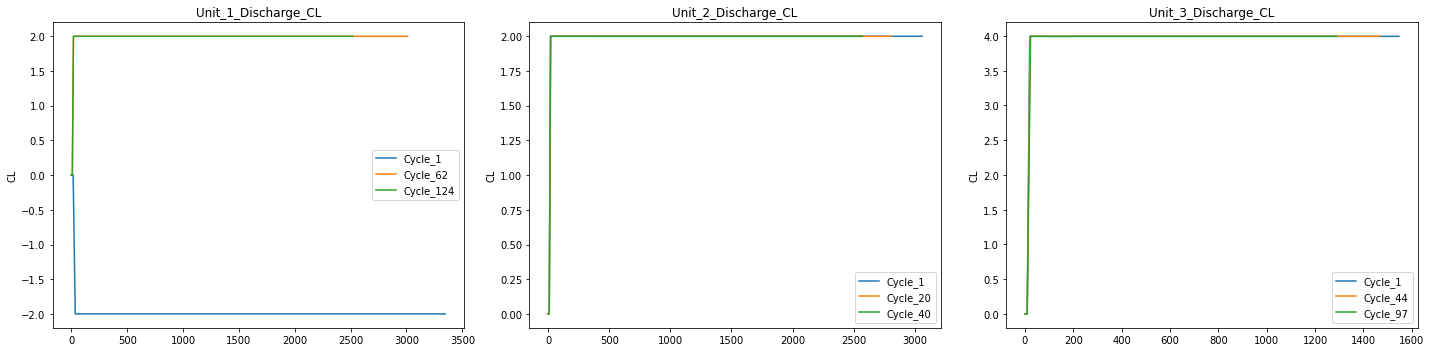

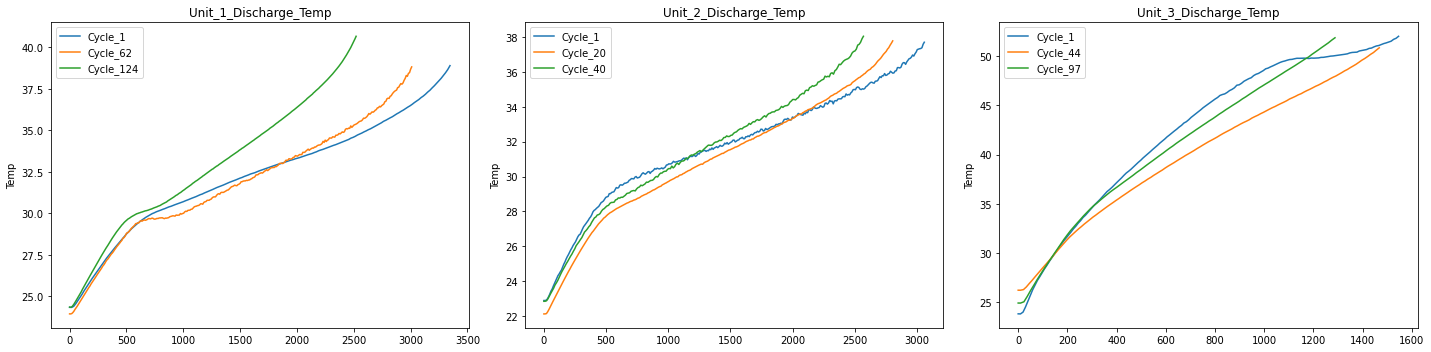

In [36]:
#放電
#mode =  'Charge'
mode =  'Discharge'

#cols = ['VM', 'CM', 'VC', 'CC', 'Temp']
cols = ['VM', 'CM', 'VL', 'CL', 'Temp']

for col in cols:
  fig = plt.figure(figsize=(20,5))

  ax1 = fig.add_subplot(1, 3, 1)#unit1
  ax2 = fig.add_subplot(1, 3, 2)#unit2
  ax3 = fig.add_subplot(1, 3, 3)#unit3

  #ユニット1
  unit = 'Train_Unit_1'

  ax1_cycle_first = 1
  ax1_cycle_mid = 62
  ax1_cycle_final = 124

  ax1_first = df[(df['mode'] == mode) & (df['Cycle'] == ax1_cycle_first) & (df['unit_name'] == unit)]
  ax1_mid = df[(df['mode'] == mode) & (df['Cycle'] == ax1_cycle_mid) & (df['unit_name'] == unit)]
  ax1_final = df[(df['mode'] == mode) & (df['Cycle'] == ax1_cycle_final) & (df['unit_name'] == unit)]

  ax1.plot(ax1_first['Time'], ax1_first[col], label=f'Cycle_{ax1_cycle_first}')
  ax1.plot(ax1_mid['Time'], ax1_mid[col], label=f'Cycle_{ax1_cycle_mid}')
  ax1.plot(ax1_final['Time'], ax1_final[col], label=f'Cycle_{ax1_cycle_final}')
  ax1.set_title(f'Unit_1_{mode}_{col}')
  ax1.set_ylabel(col)
  ax1.legend()

  #ユニット2
  unit = 'Train_Unit_2'

  ax2_cycle_first = 1
  ax2_cycle_mid = 20
  ax2_cycle_final = 40

  ax2_first = df[(df['mode'] == mode) & (df['Cycle'] == ax2_cycle_first) & (df['unit_name'] == unit)]
  ax2_mid = df[(df['mode'] == mode) & (df['Cycle'] == ax2_cycle_mid) & (df['unit_name'] == unit)]
  ax2_final = df[(df['mode'] == mode) & (df['Cycle'] == ax2_cycle_final) & (df['unit_name'] == unit)]

  ax2.plot(ax2_first['Time'], ax2_first[col], label=f'Cycle_{ax2_cycle_first}')
  ax2.plot(ax2_mid['Time'], ax2_mid[col], label=f'Cycle_{ax2_cycle_mid}')
  ax2.plot(ax2_final['Time'], ax2_final[col], label=f'Cycle_{ax2_cycle_final}')
  ax2.set_title(f'Unit_2_{mode}_{col}')
  ax2.set_ylabel(col)
  ax2.legend()

  #ユニット3
  unit = 'Train_Unit_3'

  ax3_cycle_first = 1
  ax3_cycle_mid = 44
  ax3_cycle_final = 97

  ax3_first = df[(df['mode'] == mode) & (df['Cycle'] == ax3_cycle_first) & (df['unit_name'] == unit)]
  ax3_mid = df[(df['mode'] == mode) & (df['Cycle'] == ax3_cycle_mid) & (df['unit_name'] == unit)]
  ax3_final = df[(df['mode'] == mode) & (df['Cycle'] == ax3_cycle_final) & (df['unit_name'] == unit)]

  ax3.plot(ax3_first['Time'], ax3_first[col], label=f'Cycle_{ax3_cycle_first}')
  ax3.plot(ax3_mid['Time'], ax3_mid[col], label=f'Cycle_{ax3_cycle_mid}')
  ax3.plot(ax3_final['Time'], ax3_final[col], label=f'Cycle_{ax3_cycle_final}')
  ax3.set_title(f'Unit_3_{mode}_{col}')
  ax3.set_ylabel(col)
  ax3.legend()

  fig.tight_layout()
  plt.show()